In [183]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [184]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [185]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [186]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [187]:
tf.keras.backend.clear_session()

In [188]:
subject = 'Alagoas - Consumo de Cimento (t)'
start_index = 0
split_index = 179 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 12

In [189]:
data = pd.read_csv('2003_mo_model_input_AL.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - Consumo de Cimento (t),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%)
0,2003-1,0.635160,1.594356e+06,30.109,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498
1,2003-2,0.635571,1.598004e+06,27.684,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389
2,2003-3,0.635982,1.601652e+06,26.534,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184
3,2003-4,0.636393,1.605299e+06,25.109,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287
4,2003-5,0.636804,1.608947e+06,25.171,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


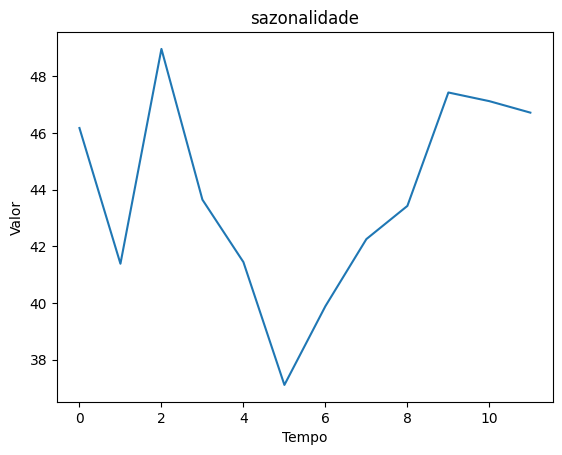

,sazonalidade
sazonalidade,
0,46.174340
1,41.382404
2,48.967201
3,43.643633
4,41.440538
5,37.102875
6,39.883331
7,42.252493
8,43.423458


In [190]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement[:train_split]})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [191]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Alagoas - IDH,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - PIB - Per Capita,Alagoas - PIB - Preços de Mercado,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade,Alagoas - Consumo de Cimento (t)
0,2003-1,0.635160,1.594356e+06,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,7.576443,2.359888e+07,0.574004,384683.093871,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,46.174340,30.109
1,2003-2,0.635571,1.598004e+06,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,7.578654,2.360861e+07,0.574517,385266.203928,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.382404,27.684
2,2003-3,0.635982,1.601652e+06,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,7.580866,2.361833e+07,0.575030,385305.059560,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.967201,26.534
3,2003-4,0.636393,1.605299e+06,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,7.583078,2.362806e+07,0.575544,385752.052697,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.643633,25.109
4,2003-5,0.636804,1.608947e+06,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,7.585289,2.363779e+07,0.576057,387164.022451,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.440538,25.171
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
244,2023-5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34203.746404,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,41.440538,NaN
245,2023-6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34166.160992,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.102875,NaN
246,2023-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34117.245244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39.883331,NaN
247,2023-8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34053.559120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.252493,NaN


In [192]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-24)
target_data

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
244       NaN
245       NaN
246       NaN
247       NaN
248       NaN
Name: Alagoas - Consumo de Cimento (t), Length: 249, dtype: float64

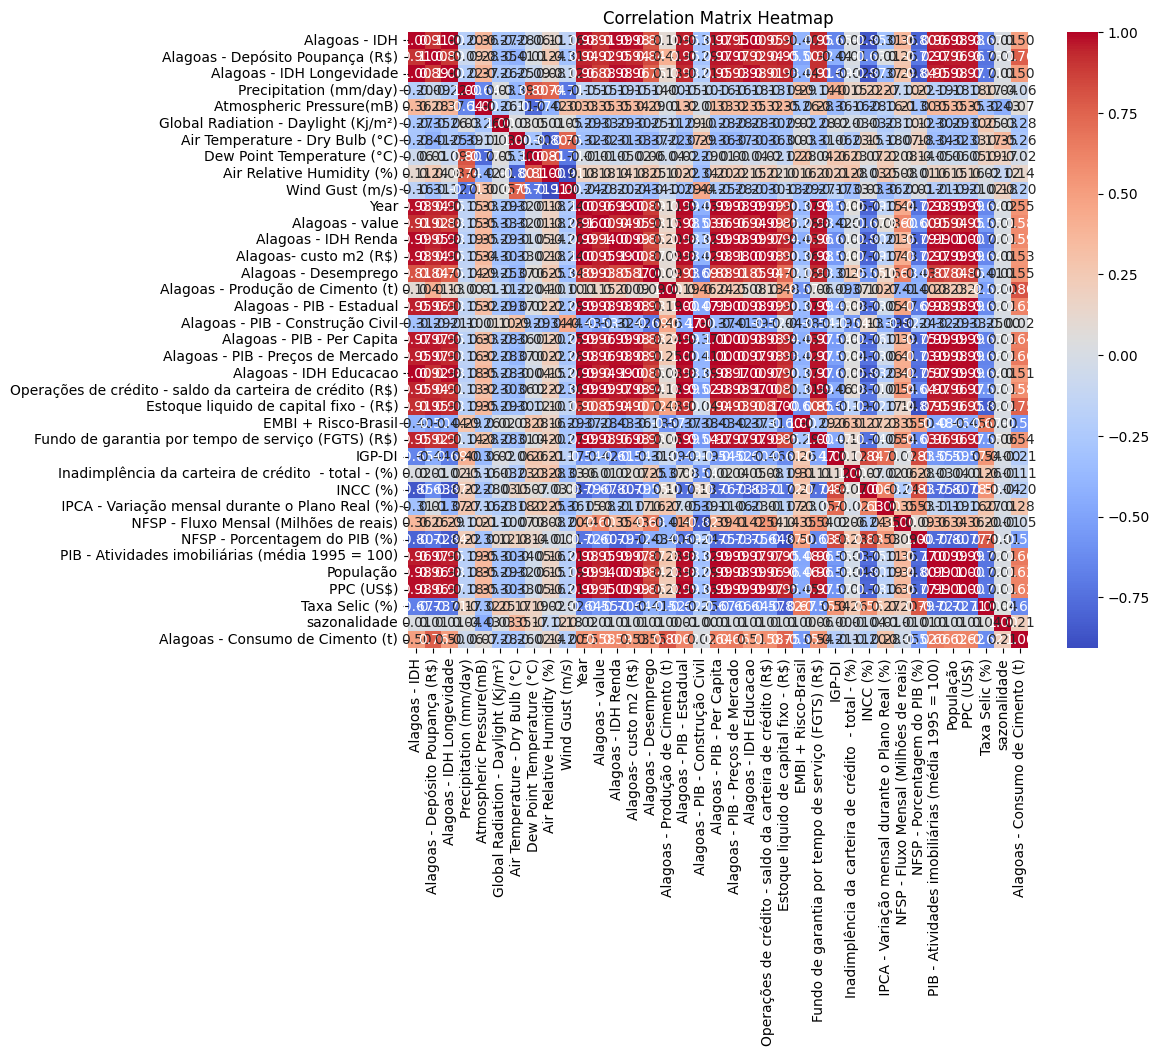

In [193]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [194]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

safe_data = data.iloc[:split_index + 1,1:-1]

def calculate_vif(dataframe):
    vif_data = pd.DataFrame()
    vif_data["Feature"] = dataframe.columns
    vif_data["VIF"] = [variance_inflation_factor(dataframe.values, i) for i in range(dataframe.shape[1])]
    return vif_data

def remove_high_vif_columns(dataframe, threshold=1000):
    i=0
    while True:
        vif_result = calculate_vif(dataframe)
        high_vif_column = vif_result.loc[vif_result["VIF"].idxmax()]["Feature"]
        
        if vif_result["VIF"].max() <= threshold:
            print(f"Num columns removed: {i}")
            return dataframe
        i += 1
        dataframe = dataframe.drop(high_vif_column, axis=1)

In [195]:
safe_data = data.iloc[:split_index + 1,1:-1]
vif_info = calculate_vif(safe_data)
vif_info

,Feature,VIF
0,Alagoas - IDH,2.423603e+10
1,Alagoas - Depósito Poupança (R$),1.182704e+05
2,Alagoas - IDH Longevidade,1.297837e+09
3,Precipitation (mm/day),2.130644e+02
4,Atmospheric Pressure(mB),2.716643e+07
5,Global Radiation - Daylight (Kj/m²),1.845293e+01
6,Air Temperature - Dry Bulb (°C),6.230382e+06
7,Dew Point Temperature (°C),4.657505e+06
8,Air Relative Humidity (%),3.233892e+06
9,Wind Gust (m/s),1.863076e+03


In [196]:
data = remove_high_vif_columns(safe_data, 1000000000)
data

Num columns removed: 3


,Alagoas - Depósito Poupança (R$),Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,1.594356e+06,0.728082,1.733015,1004.406322,2909.761327,26.020931,21.071712,75.811353,2.973119,2002.694978,0.294434,0.587982,11196.703600,8.765721,30.779440,2.590528e+07,1.303625e+06,0.574004,3.846831e+05,7.330309e+06,231.510748,2.097001e+06,1.036534,3.656420,0.969649,0.724032,-5331.049150,11.520143,126.459809,1.772069e+08,169.247665,1.611498,46.174340
1,1.598004e+06,0.728532,1.732242,1004.408335,2909.761327,26.019480,21.071203,75.813948,2.972700,2002.726142,0.296211,0.588354,11284.186677,8.760196,30.599132,2.593685e+07,1.305020e+06,0.574517,3.852662e+05,7.335910e+06,208.710157,2.000523e+06,0.993449,3.654697,0.950783,0.690297,-5318.079644,11.189862,126.581813,1.773884e+08,170.176810,1.450389,41.382404
2,1.601652e+06,0.728982,1.731790,1004.409509,2909.761327,26.018633,21.070905,75.815461,2.972455,2002.744322,0.297521,0.588725,11367.266677,8.754671,30.545910,2.596843e+07,1.306414e+06,0.575030,3.853051e+05,7.341511e+06,227.704841,1.963278e+06,0.973020,3.654266,0.938332,0.669681,-5436.417870,10.820792,126.703818,1.775699e+08,171.135713,1.870184,48.967201
3,1.605299e+06,0.729432,1.731742,1004.409635,2909.761327,26.018542,21.070874,75.815623,2.972429,2002.746270,0.298766,0.589097,11444.094177,8.749145,30.377624,2.600000e+07,1.307809e+06,0.575544,3.857521e+05,7.347112e+06,278.121073,1.954187e+06,0.940489,3.653595,0.926401,0.660494,-5707.015274,10.417840,126.825822,1.777514e+08,172.116904,1.355287,43.643633
4,1.608947e+06,0.729882,1.752976,1004.066871,2728.142601,26.084558,21.206030,76.090381,2.928113,2002.886466,0.299945,0.589469,11519.250729,8.743620,30.464900,2.603157e+07,1.309203e+06,0.576057,3.871640e+05,7.352713e+06,344.827633,1.975493e+06,0.917493,3.650266,0.951683,0.648337,-5599.317941,9.959690,126.976217,1.779329e+08,173.072271,1.585538,41.440538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,3.490268e+06,0.766342,1.311134,1006.598531,1378.429799,24.509769,20.617382,79.871178,2.693917,2016.980331,0.461941,0.631548,23294.646100,14.206051,18.851408,3.132383e+07,1.302192e+06,0.644294,3.068648e+06,7.783063e+06,273.655482,1.001735e+07,0.471521,3.683580,0.378150,0.366904,-5783.316460,2.206994,196.778355,1.987710e+08,416.859692,0.583985,42.252493
176,3.503936e+06,0.766230,1.159085,1005.993620,1456.088401,24.901282,20.732754,78.681351,2.904182,2016.986821,0.461419,0.631508,23369.030013,14.185836,18.955692,3.131883e+07,1.302193e+06,0.644368,3.070265e+06,7.780841e+06,269.131737,9.868983e+06,0.476827,3.634735,0.377666,0.358935,-6001.730740,2.215328,197.255170,1.988450e+08,417.748887,0.753312,43.423458
177,3.517604e+06,0.766117,1.311909,1005.173304,1536.429279,25.329128,20.999657,78.044222,2.974645,2017.134027,0.460904,0.631469,23439.664515,14.165621,19.215115,3.131384e+07,1.302194e+06,0.644443,3.078615e+06,7.778619e+06,265.863958,1.025520e+07,0.475427,3.545663,0.377838,0.354313,-6454.887704,2.232466,197.731985,1.989190e+08,418.601189,0.882343,47.428699
178,3.531273e+06,0.766004,1.415685,1004.445163,1585.194890,25.683125,21.305606,77.918716,3.018937,2017.300168,0.460399

In [197]:
input_data = data.iloc[:split_index + 1,1:]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.299495,0.714243,-0.406118,0.091812,0.241525,0.120112,-0.054320,0.131927,-1.702232,-1.337454,-1.980057,-1.675084,-0.812041,-1.061156,-1.592372,-1.418085,-1.851432,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.698574
1,-2.255777,0.712267,-0.404645,0.091812,0.240015,0.119580,-0.053912,0.131132,-1.694986,-1.311262,-1.951551,-1.650499,-0.814085,-1.076377,-1.575265,-1.361111,-1.826153,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.708286
2,-2.212060,0.711115,-0.403787,0.091812,0.239134,0.119270,-0.053674,0.130669,-1.690759,-1.291945,-1.923045,-1.627151,-0.816130,-1.080869,-1.558158,-1.304137,-1.800873,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,1.518527
3,-2.168342,0.710991,-0.403695,0.091812,0.239040,0.119237,-0.053648,0.130619,-1.690306,-1.273580,-1.894538,-1.605559,-0.818175,-1.095074,-1.541051,-1.247164,-1.775594,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.044414
4,-2.124625,0.765233,-0.654391,0.045158,0.307714,0.260251,-0.010386,0.046539,-1.657711,-1.256204,-1.866032,-1.584438,-0.820219,-1.087707,-1.523944,-1.190190,-1.750315,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.691218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,1.416479,-0.363433,1.197256,-0.301555,-1.330511,-0.353908,0.584917,-0.397791,1.619092,1.132403,1.362444,1.724837,1.201260,-2.068023,1.343655,-1.476659,1.610793,1.351069,0.605679,-0.193815,1.501633,-0.514871,1.296737,-1.872446,-1.429358,0.425789,-0.584804,1.266999,1.368581,1.421090,-1.472938,-0.452837
176,1.405539,-0.751838,0.754826,-0.281606,-0.923227,-0.233536,0.397574,0.001136,1.620601,1.124698,1.359434,1.745742,1.193779,-2.059221,1.340948,-1.476604,1.614441,1.352673,0.591420,-0.235540,1.449107,-0.473208,1.139013,-1.876611,-1.523783,0.339575,-0.580461,1.288102,1.380202,1.432650,-0.879688,-0.109055
177,1.394599,-0.361455,0.154850,-0.260968,-0.478146,0.044933,0.297255,0.134823,1.654826,1.117107,1.356425,1.765592,1.186298,-2.037322,1.338241,-1.476550,1.618089,1.360954,0.577161,-0.265681,1.585840,-0.484199,0.851392,-1.875135,-1.578548,0.160702,-0.571531,1.309204,1.391823,1.443731,-0.427616,1.066840
178,1.383658,-0.096363,-0.377709,-0.248441,-0.109889,0.364142,0.277493,0.218856,1.693454,1.109659,1.353415,1.785180,1.178817,-2.024551,1.335535,-1.476495,1.621737,1.365401,0.562902,-0.285262,1.756179,-0.359568,0.626702,-1.942040,-1.597335,0.244264,-0.555524,1.330436,1.403443,1.454507,-0.000772,0.976988


In [198]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
0,-2.299495,0.714243,-0.406118,0.091812,0.241525,0.120112,-0.054320,0.131927,-1.702232,-1.337454,-1.980057,-1.675084,-0.812041,-1.061156,-1.592372,-1.418085,-1.851432,-1.310937,-2.299937,-0.582539,-1.302390,3.921218,1.209036,3.214079,2.802383,0.604311,4.268118,-1.845112,-2.016914,-1.798021,2.127040,0.698574
1,-2.255777,0.712267,-0.404645,0.091812,0.240015,0.119580,-0.053912,0.131132,-1.694986,-1.311262,-1.951551,-1.650499,-0.814085,-1.076377,-1.575265,-1.361111,-1.826153,-1.310358,-2.263992,-0.792841,-1.336546,3.582946,1.203470,3.051841,2.402642,0.609431,4.096014,-1.839712,-1.988421,-1.785942,1.562580,-0.708286
2,-2.212060,0.711115,-0.403787,0.091812,0.239134,0.119270,-0.053674,0.130669,-1.690759,-1.291945,-1.923045,-1.627151,-0.816130,-1.080869,-1.558158,-1.304137,-1.800873,-1.310320,-2.228047,-0.617643,-1.349731,3.422548,1.202078,2.944772,2.158351,0.562720,3.903698,-1.834313,-1.959928,-1.773475,3.033368,1.518527
3,-2.168342,0.710991,-0.403695,0.091812,0.239040,0.119237,-0.053648,0.130619,-1.690306,-1.273580,-1.894538,-1.605559,-0.818175,-1.095074,-1.541051,-1.247164,-1.775594,-1.309876,-2.192102,-0.152627,-1.352950,3.167136,1.199914,2.842174,2.049492,0.455907,3.693727,-1.828913,-1.931435,-1.760719,1.229384,-0.044414
4,-2.124625,0.765233,-0.654391,0.045158,0.307714,0.260251,-0.010386,0.046539,-1.657711,-1.256204,-1.866032,-1.584438,-0.820219,-1.087707,-1.523944,-1.190190,-1.750315,-1.308476,-2.156157,0.462644,-1.345407,2.986591,1.189162,3.059587,1.905441,0.498418,3.454992,-1.822257,-1.902941,-1.748299,2.036088,-0.691218
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,1.522971,-1.186932,1.131869,-0.267053,-0.799296,-0.587636,0.077250,-0.281091,1.386594,1.294402,1.394641,1.456148,1.319787,-1.365958,1.343121,-1.394938,1.570248,1.407354,0.759879,0.731931,1.338281,-1.087000,1.252487,-1.491033,-0.960452,1.465326,-0.676734,1.091879,1.228701,1.261902,0.499090,-0.452837
164,1.516989,-1.156175,0.654372,-0.252286,-0.375932,-0.432511,-0.100221,0.227352,1.388103,1.275704,1.392415,1.476918,1.306555,-1.466781,1.347017,-1.411359,1.573250,1.402136,0.749001,0.583095,1.318191,-0.904679,1.414483,-1.525186,-1.007966,1.351131,-0.668750,1.100438,1.240408,1.276272,0.323875,-0.109055
165,1.511007,-1.033810,0.167315,-0.236280,0.051927,-0.296423,-0.289324,0.552099,1.422328,1.256158,1.390189,1.498470,1.293323,-1.542173,1.350913,-1.427780,1.576252,1.398719,0.738124,0.433167,1.483470,-0.900134,1.498244,-1.546744,-0.976556,1.143146,-0.657609,1.108997,1.252114,1.290351,0.198030,1.066840
166,1.505025,-1.040087,-0.192191,-0.229132,0.393188,-0.116235,-0.393532,0.598370,1.460955,1.241898,1.387963,1.520168,1.280091,-1.616426,1.354809,-1.444200,1.579254,1.393142,0.727246,0.297965,1.703486,-1.136836,1.476356,-1.586381,-1.146834,1.542609,-0.647588,1.117113,1.263821,1.304501,0.502803,0.976988


In [199]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      29.095
1      25.241
2      29.040
3      25.685
4      21.197
        ...  
163    31.782
164    27.768
165    33.073
166    30.389
167    27.657
Name: Alagoas - Consumo de Cimento (t), Length: 168, dtype: float64

In [200]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [201]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(132, 36, 32)

In [202]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size : split_index + 1]
test_input

,Alagoas - IDH Longevidade,Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Year,Alagoas - value,Alagoas - IDH Renda,Alagoas- custo m2 (R$),Alagoas - Desemprego,Alagoas - Produção de Cimento (t),Alagoas - PIB - Estadual,Alagoas - PIB - Construção Civil,Alagoas - IDH Educacao,Operações de crédito - saldo da carteira de crédito (R$),Estoque liquido de capital fixo - (R$),EMBI + Risco-Brasil,Fundo de garantia por tempo de serviço (FGTS) (R$),IGP-DI,Inadimplência da carteira de crédito - total - (%),INCC (%),IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),PIB - Atividades imobiliárias (média 1995 = 100),População,PPC (US$),Taxa Selic (%),sazonalidade
132,0.479754,-0.274868,-0.651205,-0.231023,0.143775,0.491432,0.196732,-0.431666,0.857181,1.225109,0.784884,0.708227,1.187627,1.224430,1.011047,-0.556494,0.672429,0.992500,0.965586,-0.548487,1.079517,0.174628,-1.262693,-0.066954,1.530065,0.817451,-0.366715,1.072212,0.848407,0.878252,-0.590376,0.698574
133,0.475503,-0.073422,-0.715709,-0.248529,0.100186,0.712841,0.377756,-0.694353,0.876088,1.266567,0.782230,0.729631,1.202746,1.174021,1.027579,-0.603856,0.681405,1.013803,0.962419,-0.501591,0.954387,0.240832,-1.257770,-0.130652,1.649361,1.130195,-0.350285,1.078438,0.861179,0.887574,-0.476859,-0.708286
134,0.471252,-0.200623,-0.400106,-0.266961,-0.072338,0.710197,0.488829,-0.865722,0.892178,1.308360,0.779577,0.751131,1.217865,1.121813,1.044111,-0.651218,0.690382,1.036490,0.959252,-0.487442,0.917313,0.176857,-1.179613,-0.079602,1.622916,1.160498,-0.335122,1.084663,0.873950,0.896990,-0.089952,1.518527
135,0.467001,0.032524,0.170866,-0.291428,-0.487096,0.528036,0.638912,-1.051620,0.904304,1.353623,0.776924,0.773088,1.232984,1.067857,1.060643,-0.698580,0.699359,1.059637,0.956085,-0.477666,0.905701,-0.005233,-1.150081,-0.034473,1.581460,1.131990,-0.321950,1.090889,0.886722,0.906245,-0.814200,-0.044414
136,0.462751,-0.143908,0.788878,-0.302786,-1.016116,0.104889,0.698961,-1.126419,0.911035,1.390017,0.774270,0.794785,1.248103,1.012688,1.077175,-0.745942,0.708336,1.080606,0.952918,-0.476309,0.917044,0.097576,-1.102711,-0.177535,1.638292,1.384387,-0.302995,1.095273,0.899493,0.915208,-0.917944,-0.691218
137,0.458500,-0.378454,1.296512,-0.300879,-1.323821,-0.244442,0.659610,-0.984855,0.916028,1.420202,0.771617,0.821347,1.263222,0.955865,1.093707,-0.793304,0.717313,1.101264,0.949751,-0.468224,0.926784,0.431487,-1.100246,-0.208868,1.643773,1.375487,-0.290554,1.099656,0.912265,0.924126,-0.708692,-1.964708
138,0.454249,-0.143949,1.516428,-0.296573,-1.457677,-0.396301,0.643388,-0.794986,0.919435,1.449992,0.768963,0.848309,1.278340,0.897611,1.110238,-0.840667,0.726289,1.123860,0.946584,-0.449308,0.951808,0.482414,-1.083821,-0.245300,1.704584,1.438928,-0.281926,1.104040,0.925036,0.932114,-0.496126,-1.148397
139,0.449998,0.001437,1.198328,-0.284755,-1.345627,-0.440301,0.539833,-0.509257,0.921597,1.473374,0.766310,0.873434,1.293459,0.837881,1.126770,-0.888029,0.735266,1.150086,0.943417,-0.429479,0.970898,0.657043,-1.080043,-0.333490,1.841703,1.569590,-0.275931,1.104434,0.937808,0.939863,-0.251065,-0.452837
140,0.445748,0.026216,0.843992,-0.273099,-1.033455,-0.296296,0.431087,-0.216830,0.923105,1.496217,0.763656,0.898964,1.308578,0.776766,1.143302,-0.935391,0.744243,1.179474,0.940250,-0.410867,0.982071,0.678386,-1.159959,-0.296846,1.837218,1.584058,-0.271466,1.104827,0.950580,0.947944,-0.593206,-0.109055
141,0.441497,-0.023423,0.562567,-0.259146,-0.652633,-0.186575,0.258607,-0.062478,0.957331,1.512538,0.761003,0.924954,1.323697,0.713947,1.159834,-0.982753,0.753220,1.214576,0.937082,-0.384008,1.141593,0.727143,-1.291433,-0.292462,1.797860,1.166380,-0.273241,1.105221,0.963351,0.956229,-0.100794,1.066840


In [203]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(12, 36, 32)

In [204]:
def lstm_model(train_input, train_target, 
               first_layer_n_cells, 
               second_layer_n_cells, 
               want_verbose=1, seed=0):
    
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=500,
        verbose=want_verbose,
        restore_best_weights=True,
        start_from_epoch=500
    )
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    
    model = tf.keras.Sequential()
    
    model.add(tf.keras.layers.LSTM(
        first_layer_n_cells,
        activation='tanh',
        return_sequences=(second_layer_n_cells > 0),
        kernel_regularizer=tf.keras.regularizers.l2(0.01),
        input_shape=(train_input.shape[1], train_input.shape[2])
    ))
    
    if second_layer_n_cells > 0:
        model.add(tf.keras.layers.Dropout(0.2))
        model.add(tf.keras.layers.LSTM(
            second_layer_n_cells,
            activation='tanh',
            kernel_regularizer=tf.keras.regularizers.l2(0.01)
        ))
        
    model.add(tf.keras.layers.Dense(1))
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')    
    history = model.fit(
        train_input,
        train_target,
        epochs=10000,
        validation_split=0.07,
        callbacks=[early_stopping],
        verbose=want_verbose
    )
    
    return model, history

In [205]:
def get_a_good_seed(train_input, train_target, first_layer_n_cells, second_layer_n_cells):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(10)]
    list_loss = []
    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, 
                                    first_layer_n_cells, second_layer_n_cells,
                                    want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        list_loss.append(current_loss)
        print(f"val_loss: {current_loss}")
        print(f"mean_loss: {np.mean(list_loss)}")
        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed, np.mean(list_loss)

    return winner_seed, np.mean(list_loss)

In [206]:
# Tuning range
first_layer_cells_list = [36, 72, 144]
second_layer_cells_list = [0, 36, 72, 144]

In [207]:
def hyperparameter_tuning(train_input, train_target, first_layer_cells_list, second_layer_cells_list):
    
    best_loss = float('inf')
    best_combination = None
    
    for first_cells in first_layer_cells_list:
        for second_cells in second_layer_cells_list:
            print(f"_________________________________________________________________________________________")
            print(" ")
            print(f"Testing [{first_cells}, {second_cells}]")
            print(f"_________________________________________________________________________________________")

            winner_seed, mean_loss = get_a_good_seed(train_input, train_target, 
                                                        first_cells, second_cells)
            print(" ")
            print(f"first_layer_n_cells: {first_cells}")
            print(f"second_layer_n_cells: {second_cells}")
            if mean_loss < best_loss:
                best_loss = mean_loss
                best_combination = [first_cells, second_cells, winner_seed]
                print(f"best_loss: {best_loss}")
                print(f"winner_seed: {winner_seed}")
            print(" ")
            
    return best_combination

In [208]:
best_combination = hyperparameter_tuning(reshaped_train, 
                                         reshaped_target, 
                                         first_layer_cells_list, 
                                         second_layer_cells_list)
best_combination

_________________________________________________________________________________________
 
Testing [36, 0]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 37.54118347167969
mean_loss: 37.54118347167969
winner_seed: 1879854764


Step: 1 ___________________________________________
val_loss: 51.89832305908203
mean_loss: 44.71975326538086


Step: 2 ___________________________________________
val_loss: 229.06436157226562
mean_loss: 106.16795603434245


Step: 3 ___________________________________________
val_loss: 98.07060241699219
mean_loss: 104.14361763000488


Step: 4 ___________________________________________
val_loss: 16.355648040771484
mean_loss: 86.58602371215821
winner_seed: 1295553018


Step: 5 ___________________________________________
val_loss: 130.04347229003906
mean_loss: 93.82893180847168


Step: 6 ___________________________________________
val_loss: 203.40000915527344


val_loss: 7.619057655334473
mean_loss: 9.034191370010376


Step: 8 ___________________________________________
val_loss: 8.419280052185059
mean_loss: 8.965867890252007


Step: 9 ___________________________________________
val_loss: 8.116929054260254
mean_loss: 8.880974006652831
 
first_layer_n_cells: 72
second_layer_n_cells: 36
 
_________________________________________________________________________________________
 
Testing [72, 72]
_________________________________________________________________________________________


Step: 0 ___________________________________________
val_loss: 8.392026901245117
mean_loss: 8.392026901245117
winner_seed: 1574158463


Step: 1 ___________________________________________
val_loss: 13.35978889465332
mean_loss: 10.875907897949219


Step: 2 ___________________________________________
val_loss: 10.691755294799805
mean_loss: 10.814523696899414


Step: 3 ___________________________________________
val_loss: 8.71330738067627
mean_loss: 10.28921961784362

val_loss: 12.820276260375977
mean_loss: 7.808748722076416


Step: 5 ___________________________________________
val_loss: 7.24245548248291
mean_loss: 7.714366515477498


Step: 6 ___________________________________________
val_loss: 5.969832897186279
mean_loss: 7.465147427150181


Step: 7 ___________________________________________
val_loss: 12.9910306930542
mean_loss: 8.155882835388184


Step: 8 ___________________________________________
val_loss: 7.415487766265869
mean_loss: 8.073616716596815


Step: 9 ___________________________________________
val_loss: 9.523231506347656
mean_loss: 8.218578195571899
 
first_layer_n_cells: 144
second_layer_n_cells: 144
best_loss: 8.218578195571899
winner_seed: 1263739727
 


[144, 144, 1263739727]

In [213]:
best_combination

[144, 144, 1263739727]

In [209]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target,
                                    best_combination[0], best_combination[1], 
                                    want_verbose=1, 
                                    seed=best_combination[2])

Epoch 1/10000
4/4 [==============================] - 2s 128ms/step - loss: 2232.7051 - val_loss: 193.0437
Epoch 2/10000
4/4 [==============================] - 0s 11ms/step - loss: 367.4406 - val_loss: 350.9549
Epoch 3/10000
4/4 [==============================] - 0s 11ms/step - loss: 172.5546 - val_loss: 59.4815
Epoch 4/10000
4/4 [==============================] - 0s 11ms/step - loss: 185.0481 - val_loss: 477.9413
Epoch 5/10000
4/4 [==============================] - 0s 11ms/step - loss: 140.0175 - val_loss: 129.2160
Epoch 6/10000
4/4 [==============================] - 0s 11ms/step - loss: 85.5386 - val_loss: 160.3970
Epoch 7/10000
4/4 [==============================] - 0s 11ms/step - loss: 179.2841 - val_loss: 14.2635
Epoch 8/10000
4/4 [==============================] - 0s 10ms/step - loss: 90.0242 - val_loss: 73.3337
Epoch 9/10000
4/4 [==============================] - 0s 10ms/step - loss: 68.8268 - val_loss: 146.1266
Epoch 10/10000
4/4 [==============================] - 0s 11ms/step -

4/4 [==============================] - 0s 11ms/step - loss: 17.7064 - val_loss: 11.2121
Epoch 81/10000
4/4 [==============================] - 0s 10ms/step - loss: 19.8681 - val_loss: 12.1330
Epoch 82/10000
4/4 [==============================] - 0s 10ms/step - loss: 20.5992 - val_loss: 11.1154
Epoch 83/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.2433 - val_loss: 11.2305
Epoch 84/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.5074 - val_loss: 13.1432
Epoch 85/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.3216 - val_loss: 11.4154
Epoch 86/10000
4/4 [==============================] - 0s 11ms/step - loss: 19.4411 - val_loss: 11.4412
Epoch 87/10000
4/4 [==============================] - 0s 11ms/step - loss: 18.3171 - val_loss: 11.6172
Epoch 88/10000
4/4 [==============================] - 0s 11ms/step - loss: 16.9920 - val_loss: 11.9754
Epoch 89/10000
4/4 [==============================] - 0s 11ms/step - loss: 17.3198 - val

4/4 [==============================] - 0s 10ms/step - loss: 14.2480 - val_loss: 14.3073
Epoch 160/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.6412 - val_loss: 16.9868
Epoch 161/10000
4/4 [==============================] - 0s 10ms/step - loss: 13.9457 - val_loss: 15.7402
Epoch 162/10000
4/4 [==============================] - 0s 10ms/step - loss: 17.0937 - val_loss: 16.3818
Epoch 163/10000
4/4 [==============================] - 0s 11ms/step - loss: 13.2371 - val_loss: 14.2098
Epoch 164/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.3434 - val_loss: 15.0020
Epoch 165/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.7969 - val_loss: 14.8191
Epoch 166/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.6132 - val_loss: 15.5416
Epoch 167/10000
4/4 [==============================] - 0s 11ms/step - loss: 14.0797 - val_loss: 14.7104
Epoch 168/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.2

Epoch 238/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.8137 - val_loss: 14.2183
Epoch 239/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.1676 - val_loss: 14.7058
Epoch 240/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.1211 - val_loss: 16.2737
Epoch 241/10000
4/4 [==============================] - 0s 10ms/step - loss: 14.0909 - val_loss: 14.8446
Epoch 242/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.9679 - val_loss: 15.2064
Epoch 243/10000
4/4 [==============================] - 0s 11ms/step - loss: 11.8703 - val_loss: 15.0600
Epoch 244/10000
4/4 [==============================] - 0s 11ms/step - loss: 12.5604 - val_loss: 19.3535
Epoch 245/10000
4/4 [==============================] - 0s 10ms/step - loss: 16.0799 - val_loss: 17.8311
Epoch 246/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.2284 - val_loss: 16.4071
Epoch 247/10000
4/4 [==============================] - 0s 11ms/s

Epoch 317/10000
4/4 [==============================] - 0s 13ms/step - loss: 11.5812 - val_loss: 15.6923
Epoch 318/10000
4/4 [==============================] - 0s 9ms/step - loss: 10.3610 - val_loss: 14.2399
Epoch 319/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.4459 - val_loss: 13.7301
Epoch 320/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.0964 - val_loss: 15.7736
Epoch 321/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.8709 - val_loss: 14.1717
Epoch 322/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.6300 - val_loss: 14.1096
Epoch 323/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.3027 - val_loss: 15.6381
Epoch 324/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.0063 - val_loss: 14.8889
Epoch 325/10000
4/4 [==============================] - 0s 10ms/step - loss: 11.1285 - val_loss: 15.7226
Epoch 326/10000
4/4 [==============================] - 0s 9ms/ste

4/4 [==============================] - 0s 11ms/step - loss: 12.0736 - val_loss: 13.7991
Epoch 397/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.7046 - val_loss: 13.5226
Epoch 398/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.5024 - val_loss: 16.7262
Epoch 399/10000
4/4 [==============================] - 0s 12ms/step - loss: 10.4530 - val_loss: 15.1667
Epoch 400/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.2341 - val_loss: 15.0382
Epoch 401/10000
4/4 [==============================] - 0s 10ms/step - loss: 12.5661 - val_loss: 14.5829
Epoch 402/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.5038 - val_loss: 15.6418
Epoch 403/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.7484 - val_loss: 13.8042
Epoch 404/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.8886 - val_loss: 13.9181
Epoch 405/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.1517

4/4 [==============================] - 0s 9ms/step - loss: 9.7147 - val_loss: 18.5365
Epoch 476/10000
4/4 [==============================] - 0s 10ms/step - loss: 10.5175 - val_loss: 14.5212
Epoch 477/10000
4/4 [==============================] - 0s 10ms/step - loss: 9.6887 - val_loss: 13.3202
Epoch 478/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.5513 - val_loss: 15.6990
Epoch 479/10000
4/4 [==============================] - 0s 11ms/step - loss: 10.1485 - val_loss: 14.4955
Epoch 480/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.9489 - val_loss: 17.0123
Epoch 481/10000
4/4 [==============================] - 0s 9ms/step - loss: 8.1740 - val_loss: 16.5623
Epoch 482/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.3256 - val_loss: 14.2631
Epoch 483/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.3529 - val_loss: 13.5917
Epoch 484/10000
4/4 [==============================] - 0s 9ms/step - loss: 9.0238 - val_loss

Epoch 555/10000
4/4 [==============================] - 0s 11ms/step - loss: 8.6005 - val_loss: 14.7197
Epoch 556/10000
4/4 [==============================] - 0s 11ms/step - loss: 9.7785 - val_loss: 14.9893
Epoch 557/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3183 - val_loss: 14.4588
Epoch 558/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.0660 - val_loss: 14.1505
Epoch 559/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3253 - val_loss: 14.7384
Epoch 560/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.9981 - val_loss: 13.3965
Epoch 561/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6417 - val_loss: 15.0173
Epoch 562/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.5775 - val_loss: 14.5414
Epoch 563/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3985 - val_loss: 14.1264
Epoch 564/10000
4/4 [==============================] - 0s 10ms/step - los

4/4 [==============================] - 0s 10ms/step - loss: 7.1546 - val_loss: 14.3205
Epoch 635/10000
4/4 [==============================] - 0s 9ms/step - loss: 6.8674 - val_loss: 14.1131
Epoch 636/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2018 - val_loss: 14.3336
Epoch 637/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2820 - val_loss: 13.2404
Epoch 638/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.6046 - val_loss: 14.1506
Epoch 639/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.4272 - val_loss: 13.2350
Epoch 640/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.3439 - val_loss: 13.6074
Epoch 641/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.8321 - val_loss: 13.1214
Epoch 642/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.6367 - val_loss: 14.4408
Epoch 643/10000
4/4 [==============================] - 0s 10ms/step - loss: 8.2765 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 7.8186 - val_loss: 18.4919
Epoch 714/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.3732 - val_loss: 13.8897
Epoch 715/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2849 - val_loss: 15.0747
Epoch 716/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.0757 - val_loss: 15.1772
Epoch 717/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.8976 - val_loss: 14.5066
Epoch 718/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8961 - val_loss: 15.4441
Epoch 719/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.9995 - val_loss: 15.1216
Epoch 720/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.9366 - val_loss: 14.3902
Epoch 721/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.9643 - val_loss: 15.0784
Epoch 722/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.2580 - val_

4/4 [==============================] - 0s 10ms/step - loss: 7.2079 - val_loss: 13.8740
Epoch 793/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.1200 - val_loss: 14.2168
Epoch 794/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.4151 - val_loss: 13.4502
Epoch 795/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.2450 - val_loss: 14.2073
Epoch 796/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5110 - val_loss: 13.3356
Epoch 797/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.5913 - val_loss: 13.0979
Epoch 798/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3197 - val_loss: 12.0299
Epoch 799/10000
4/4 [==============================] - 0s 11ms/step - loss: 7.4018 - val_loss: 13.5083
Epoch 800/10000
4/4 [==============================] - 0s 10ms/step - loss: 7.0082 - val_loss: 12.8481
Epoch 801/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.8964 - val_

4/4 [==============================] - 0s 10ms/step - loss: 5.6840 - val_loss: 14.8671
Epoch 872/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0237 - val_loss: 13.8891
Epoch 873/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3258 - val_loss: 13.6648
Epoch 874/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9238 - val_loss: 12.5879
Epoch 875/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.3520 - val_loss: 14.3782
Epoch 876/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.1829 - val_loss: 14.8020
Epoch 877/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.9767 - val_loss: 13.1297
Epoch 878/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0182 - val_loss: 12.7263
Epoch 879/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.4231 - val_loss: 13.2554
Epoch 880/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.4275 - val_

4/4 [==============================] - 0s 11ms/step - loss: 6.0236 - val_loss: 13.0741
Epoch 951/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3683 - val_loss: 13.6695
Epoch 952/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.7496 - val_loss: 12.0338
Epoch 953/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.2294 - val_loss: 12.4573
Epoch 954/10000
4/4 [==============================] - 0s 12ms/step - loss: 6.2726 - val_loss: 14.7189
Epoch 955/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.1821 - val_loss: 12.3251
Epoch 956/10000
4/4 [==============================] - 0s 13ms/step - loss: 6.1370 - val_loss: 12.6127
Epoch 957/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.2820 - val_loss: 12.6528
Epoch 958/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.6867 - val_loss: 14.4128
Epoch 959/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4880 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 5.2957 - val_loss: 14.4685
Epoch 1030/10000
4/4 [==============================] - 0s 9ms/step - loss: 5.4365 - val_loss: 13.3905
Epoch 1031/10000
4/4 [==============================] - 0s 10ms/step - loss: 6.0504 - val_loss: 11.5414
Epoch 1032/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9166 - val_loss: 13.7423
Epoch 1033/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.9050 - val_loss: 13.4220
Epoch 1034/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.8961 - val_loss: 11.7514
Epoch 1035/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.9908 - val_loss: 12.1783
Epoch 1036/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.1446 - val_loss: 12.2059
Epoch 1037/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8538 - val_loss: 11.6694
Epoch 1038/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.020

Epoch 1108/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1001 - val_loss: 11.1436
Epoch 1109/10000
4/4 [==============================] - 0s 10ms/step - loss: 5.3238 - val_loss: 11.7101
Epoch 1110/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8014 - val_loss: 11.7937
Epoch 1111/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1511 - val_loss: 12.4040
Epoch 1112/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6458 - val_loss: 11.5836
Epoch 1113/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.1123 - val_loss: 11.5551
Epoch 1114/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3602 - val_loss: 12.3845
Epoch 1115/10000
4/4 [==============================] - 0s 11ms/step - loss: 6.0597 - val_loss: 12.2862
Epoch 1116/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.0833 - val_loss: 14.4054
Epoch 1117/10000
4/4 [==============================] - 0s 12ms/

Epoch 1187/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.4888 - val_loss: 11.3856
Epoch 1188/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4208 - val_loss: 11.4271
Epoch 1189/10000
4/4 [==============================] - 0s 12ms/step - loss: 5.1229 - val_loss: 11.7696
Epoch 1190/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5723 - val_loss: 11.0350
Epoch 1191/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.7377 - val_loss: 11.6812
Epoch 1192/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7296 - val_loss: 11.5133
Epoch 1193/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.7290 - val_loss: 11.5278
Epoch 1194/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.8244 - val_loss: 11.3229
Epoch 1195/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9650 - val_loss: 11.8960
Epoch 1196/10000
4/4 [==============================] - 0s 10ms/

Epoch 1266/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.8689 - val_loss: 12.0825
Epoch 1267/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4560 - val_loss: 12.4783
Epoch 1268/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1241 - val_loss: 11.1791
Epoch 1269/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.3762 - val_loss: 11.5281
Epoch 1270/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3310 - val_loss: 11.4089
Epoch 1271/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5824 - val_loss: 11.0106
Epoch 1272/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4056 - val_loss: 11.7550
Epoch 1273/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.7155 - val_loss: 13.0732
Epoch 1274/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.6609 - val_loss: 13.6431
Epoch 1275/10000
4/4 [==============================] - 0s 11ms/

Epoch 1345/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9804 - val_loss: 12.4490
Epoch 1346/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.2022 - val_loss: 11.0509
Epoch 1347/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1520 - val_loss: 11.2654
Epoch 1348/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.6170 - val_loss: 11.3019
Epoch 1349/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.5041 - val_loss: 11.0451
Epoch 1350/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.3985 - val_loss: 11.1386
Epoch 1351/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.4070 - val_loss: 12.0970
Epoch 1352/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0074 - val_loss: 10.8947
Epoch 1353/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8182 - val_loss: 11.3445
Epoch 1354/10000
4/4 [==============================] - 0s 10ms/

Epoch 1424/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1121 - val_loss: 11.8771
Epoch 1425/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.0361 - val_loss: 10.3864
Epoch 1426/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9110 - val_loss: 11.3774
Epoch 1427/10000
4/4 [==============================] - 0s 12ms/step - loss: 4.1428 - val_loss: 11.6892
Epoch 1428/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7707 - val_loss: 11.9126
Epoch 1429/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7198 - val_loss: 12.2963
Epoch 1430/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.9036 - val_loss: 10.9437
Epoch 1431/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.5706 - val_loss: 10.7620
Epoch 1432/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9542 - val_loss: 10.8912
Epoch 1433/10000
4/4 [==============================] - 0s 11ms/

Epoch 1503/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.7518 - val_loss: 11.7585
Epoch 1504/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.6613 - val_loss: 11.6844
Epoch 1505/10000
4/4 [==============================] - 0s 10ms/step - loss: 4.1071 - val_loss: 10.4935
Epoch 1506/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5612 - val_loss: 10.9398
Epoch 1507/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9175 - val_loss: 10.7500
Epoch 1508/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5806 - val_loss: 11.0103
Epoch 1509/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.9460 - val_loss: 11.5023
Epoch 1510/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.7563 - val_loss: 10.9727
Epoch 1511/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.4970 - val_loss: 10.1292
Epoch 1512/10000
4/4 [==============================] - 0s 11ms/

Epoch 1582/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5257 - val_loss: 10.6300
Epoch 1583/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4579 - val_loss: 10.1959
Epoch 1584/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.8097 - val_loss: 9.7042
Epoch 1585/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.6264 - val_loss: 10.4054
Epoch 1586/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2651 - val_loss: 9.8189
Epoch 1587/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.7551 - val_loss: 10.5534
Epoch 1588/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5914 - val_loss: 10.1518
Epoch 1589/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.6615 - val_loss: 9.9417
Epoch 1590/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5906 - val_loss: 10.4468
Epoch 1591/10000
4/4 [==============================] - 0s 10ms/ste

Epoch 1661/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2774 - val_loss: 10.2074
Epoch 1662/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2699 - val_loss: 10.4159
Epoch 1663/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4630 - val_loss: 10.3556
Epoch 1664/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2044 - val_loss: 9.7149
Epoch 1665/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3930 - val_loss: 9.9094
Epoch 1666/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2011 - val_loss: 9.8123
Epoch 1667/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4573 - val_loss: 9.8639
Epoch 1668/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.0122 - val_loss: 10.3400
Epoch 1669/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3708 - val_loss: 9.7708
Epoch 1670/10000
4/4 [==============================] - 0s 11ms/step 

4/4 [==============================] - 0s 10ms/step - loss: 3.3497 - val_loss: 9.0259
Epoch 1741/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.2126 - val_loss: 9.7345
Epoch 1742/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.4385 - val_loss: 10.8249
Epoch 1743/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5571 - val_loss: 9.4273
Epoch 1744/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.9121 - val_loss: 9.7155
Epoch 1745/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6098 - val_loss: 10.0116
Epoch 1746/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9292 - val_loss: 9.2203
Epoch 1747/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2671 - val_loss: 9.8474
Epoch 1748/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2136 - val_loss: 9.7053
Epoch 1749/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0528 - va

4/4 [==============================] - 0s 10ms/step - loss: 2.5939 - val_loss: 9.3794
Epoch 1820/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1587 - val_loss: 10.0009
Epoch 1821/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0407 - val_loss: 9.5330
Epoch 1822/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9505 - val_loss: 9.5050
Epoch 1823/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9828 - val_loss: 9.2467
Epoch 1824/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2262 - val_loss: 9.1020
Epoch 1825/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.8246 - val_loss: 8.6552
Epoch 1826/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0208 - val_loss: 10.0732
Epoch 1827/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.8586 - val_loss: 9.4510
Epoch 1828/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9974 - va

4/4 [==============================] - 0s 11ms/step - loss: 3.3890 - val_loss: 9.0860
Epoch 1899/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2746 - val_loss: 9.4139
Epoch 1900/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5196 - val_loss: 9.4196
Epoch 1901/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9165 - val_loss: 8.7222
Epoch 1902/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9171 - val_loss: 8.9034
Epoch 1903/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0700 - val_loss: 9.1709
Epoch 1904/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0226 - val_loss: 9.3987
Epoch 1905/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1194 - val_loss: 9.1038
Epoch 1906/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.8702 - val_loss: 8.6826
Epoch 1907/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.3747 - val_

4/4 [==============================] - 0s 9ms/step - loss: 3.0308 - val_loss: 9.3769
Epoch 1979/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0392 - val_loss: 9.2310
Epoch 1980/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.8359 - val_loss: 8.6461
Epoch 1981/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.0270 - val_loss: 9.1302
Epoch 1982/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9087 - val_loss: 8.4254
Epoch 1983/10000
4/4 [==============================] - 0s 11ms/step - loss: 4.1195 - val_loss: 8.0363
Epoch 1984/10000
4/4 [==============================] - 0s 13ms/step - loss: 4.3832 - val_loss: 8.5643
Epoch 1985/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9069 - val_loss: 8.3447
Epoch 1986/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.1749 - val_loss: 8.8284
Epoch 1987/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9954 - val_lo

4/4 [==============================] - 0s 10ms/step - loss: 3.0512 - val_loss: 9.7531
Epoch 2058/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.8843 - val_loss: 8.4206
Epoch 2059/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6035 - val_loss: 8.5616
Epoch 2060/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5675 - val_loss: 8.6240
Epoch 2061/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.8270 - val_loss: 7.9455
Epoch 2062/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.0464 - val_loss: 8.5266
Epoch 2063/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6098 - val_loss: 8.9933
Epoch 2064/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.4873 - val_loss: 8.3560
Epoch 2065/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9445 - val_loss: 8.3907
Epoch 2066/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.7023 - val_

4/4 [==============================] - 0s 11ms/step - loss: 2.7008 - val_loss: 8.8192
Epoch 2137/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.6656 - val_loss: 8.5354
Epoch 2138/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.5832 - val_loss: 8.4545
Epoch 2139/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4992 - val_loss: 8.5412
Epoch 2140/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3111 - val_loss: 8.7359
Epoch 2141/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.4865 - val_loss: 8.5315
Epoch 2142/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.5661 - val_loss: 8.8689
Epoch 2143/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.9032 - val_loss: 8.3356
Epoch 2144/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.5848 - val_loss: 8.3347
Epoch 2145/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3556 - val_

4/4 [==============================] - 0s 10ms/step - loss: 2.6349 - val_loss: 8.6303
Epoch 2216/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2477 - val_loss: 8.1583
Epoch 2217/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2876 - val_loss: 8.5669
Epoch 2218/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5597 - val_loss: 8.2646
Epoch 2219/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2589 - val_loss: 8.0159
Epoch 2220/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4874 - val_loss: 8.2290
Epoch 2221/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3746 - val_loss: 8.3001
Epoch 2222/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3378 - val_loss: 8.6842
Epoch 2223/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3907 - val_loss: 8.1863
Epoch 2224/10000
4/4 [==============================] - 0s 11ms/step - loss: 5.3881 - val_

4/4 [==============================] - 0s 11ms/step - loss: 2.5116 - val_loss: 9.1727
Epoch 2295/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5609 - val_loss: 8.1101
Epoch 2296/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.2412 - val_loss: 8.2194
Epoch 2297/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1202 - val_loss: 8.2461
Epoch 2298/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3643 - val_loss: 8.4771
Epoch 2299/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.4620 - val_loss: 8.7395
Epoch 2300/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3811 - val_loss: 8.5111
Epoch 2301/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1354 - val_loss: 8.3738
Epoch 2302/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.3384 - val_loss: 8.2668
Epoch 2303/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0126 - val_loss:

Epoch 2374/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4757 - val_loss: 8.4259
Epoch 2375/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2511 - val_loss: 7.9582
Epoch 2376/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2620 - val_loss: 7.7383
Epoch 2377/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2655 - val_loss: 8.1352
Epoch 2378/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2984 - val_loss: 8.0811
Epoch 2379/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1876 - val_loss: 8.3014
Epoch 2380/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2464 - val_loss: 8.1151
Epoch 2381/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0734 - val_loss: 8.4750
Epoch 2382/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3737 - val_loss: 8.0950
Epoch 2383/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 11ms/step - loss: 2.1038 - val_loss: 7.9375
Epoch 2454/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.3212 - val_loss: 7.7048
Epoch 2455/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0239 - val_loss: 8.1800
Epoch 2456/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0956 - val_loss: 7.8351
Epoch 2457/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9458 - val_loss: 7.8592
Epoch 2458/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1579 - val_loss: 7.6993
Epoch 2459/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1311 - val_loss: 7.8534
Epoch 2460/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0516 - val_loss: 8.0810
Epoch 2461/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8415 - val_loss: 7.9225
Epoch 2462/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9757 - val_

4/4 [==============================] - 0s 12ms/step - loss: 2.4221 - val_loss: 8.2160
Epoch 2533/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1724 - val_loss: 8.6439
Epoch 2534/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4415 - val_loss: 8.1603
Epoch 2535/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0585 - val_loss: 8.0934
Epoch 2536/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9399 - val_loss: 8.3306
Epoch 2537/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0263 - val_loss: 7.9303
Epoch 2538/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7941 - val_loss: 7.5733
Epoch 2539/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0685 - val_loss: 7.6520
Epoch 2540/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9907 - val_loss: 7.6940
Epoch 2541/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9932 - val_

4/4 [==============================] - 0s 10ms/step - loss: 2.0090 - val_loss: 8.3338
Epoch 2612/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9496 - val_loss: 7.5997
Epoch 2613/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9259 - val_loss: 8.0755
Epoch 2614/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9148 - val_loss: 8.0370
Epoch 2615/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9110 - val_loss: 8.1419
Epoch 2616/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8235 - val_loss: 7.7375
Epoch 2617/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7281 - val_loss: 7.3692
Epoch 2618/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.1010 - val_loss: 7.6760
Epoch 2619/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6996 - val_loss: 7.4283
Epoch 2620/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9741 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.8320 - val_loss: 7.2291
Epoch 2691/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7817 - val_loss: 7.7342
Epoch 2692/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7155 - val_loss: 7.5404
Epoch 2693/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7739 - val_loss: 7.6928
Epoch 2694/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7191 - val_loss: 8.1891
Epoch 2695/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8212 - val_loss: 7.5664
Epoch 2696/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9603 - val_loss: 7.7914
Epoch 2697/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.8074 - val_loss: 7.7666
Epoch 2698/10000
4/4 [==============================] - 0s 14ms/step - loss: 1.8440 - val_loss: 8.1970
Epoch 2699/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8289 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.6874 - val_loss: 7.3927
Epoch 2770/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.6316 - val_loss: 7.5211
Epoch 2771/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6736 - val_loss: 7.5791
Epoch 2772/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8933 - val_loss: 7.6915
Epoch 2773/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8952 - val_loss: 7.4190
Epoch 2774/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6235 - val_loss: 7.4447
Epoch 2775/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8677 - val_loss: 7.5383
Epoch 2776/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7647 - val_loss: 7.6118
Epoch 2777/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9371 - val_loss: 7.7268
Epoch 2778/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7194 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 1.5778 - val_loss: 7.2088
Epoch 2849/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6073 - val_loss: 7.3808
Epoch 2850/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6774 - val_loss: 7.5138
Epoch 2851/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7060 - val_loss: 7.1670
Epoch 2852/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8562 - val_loss: 7.8935
Epoch 2853/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6542 - val_loss: 7.9324
Epoch 2854/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8063 - val_loss: 7.7304
Epoch 2855/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6143 - val_loss: 7.5513
Epoch 2856/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8653 - val_loss: 7.2949
Epoch 2857/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7344 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.4928 - val_loss: 7.8697
Epoch 2928/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7707 - val_loss: 7.5527
Epoch 2929/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6671 - val_loss: 7.3784
Epoch 2930/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7195 - val_loss: 7.7278
Epoch 2931/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6927 - val_loss: 8.0558
Epoch 2932/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7205 - val_loss: 7.5932
Epoch 2933/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5765 - val_loss: 7.3691
Epoch 2934/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5430 - val_loss: 7.3412
Epoch 2935/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6891 - val_loss: 7.5996
Epoch 2936/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7077 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.4622 - val_loss: 7.7009
Epoch 3007/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5956 - val_loss: 7.6266
Epoch 3008/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6806 - val_loss: 7.4615
Epoch 3009/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5169 - val_loss: 7.8021
Epoch 3010/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7037 - val_loss: 7.6823
Epoch 3011/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6245 - val_loss: 8.0655
Epoch 3012/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4910 - val_loss: 7.8914
Epoch 3013/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8572 - val_loss: 7.3297
Epoch 3014/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6152 - val_loss: 7.7484
Epoch 3015/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4285 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.4229 - val_loss: 7.6506
Epoch 3086/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5352 - val_loss: 7.7195
Epoch 3087/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8745 - val_loss: 7.7897
Epoch 3088/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5191 - val_loss: 7.1369
Epoch 3089/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5182 - val_loss: 7.2828
Epoch 3090/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6769 - val_loss: 7.6574
Epoch 3091/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5320 - val_loss: 7.3124
Epoch 3092/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5661 - val_loss: 7.3976
Epoch 3093/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5166 - val_loss: 6.9619
Epoch 3094/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7374 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.4931 - val_loss: 7.1770
Epoch 3165/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6577 - val_loss: 7.2207
Epoch 3166/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4221 - val_loss: 7.6010
Epoch 3167/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3666 - val_loss: 7.1252
Epoch 3168/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4697 - val_loss: 6.9010
Epoch 3169/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3692 - val_loss: 6.9901
Epoch 3170/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4252 - val_loss: 7.7739
Epoch 3171/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.6291 - val_loss: 6.9442
Epoch 3172/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4169 - val_loss: 7.1660
Epoch 3173/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5562 - val_

Epoch 3244/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4568 - val_loss: 7.2694
Epoch 3245/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4601 - val_loss: 7.1068
Epoch 3246/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.2923 - val_loss: 7.2553
Epoch 3247/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.3896 - val_loss: 7.1519
Epoch 3248/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4713 - val_loss: 7.3392
Epoch 3249/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5365 - val_loss: 7.2237
Epoch 3250/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4387 - val_loss: 7.2419
Epoch 3251/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3334 - val_loss: 7.0108
Epoch 3252/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3626 - val_loss: 7.4879
Epoch 3253/10000
4/4 [==============================] - 0s 9ms/step - los

Epoch 3324/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.6350 - val_loss: 7.2350
Epoch 3325/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4811 - val_loss: 6.8912
Epoch 3326/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4110 - val_loss: 6.8214
Epoch 3327/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7153 - val_loss: 6.9727
Epoch 3328/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.3780 - val_loss: 6.7911
Epoch 3329/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1858 - val_loss: 7.0155
Epoch 3330/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4811 - val_loss: 6.7924
Epoch 3331/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3958 - val_loss: 6.9345
Epoch 3332/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.4403 - val_loss: 7.2086
Epoch 3333/10000
4/4 [==============================] - 0s 10ms/step - loss:

4/4 [==============================] - 0s 11ms/step - loss: 1.2319 - val_loss: 6.8199
Epoch 3404/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4570 - val_loss: 6.9035
Epoch 3405/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.4023 - val_loss: 7.6489
Epoch 3406/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3993 - val_loss: 7.1451
Epoch 3407/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.2024 - val_loss: 7.3374
Epoch 3408/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1741 - val_loss: 7.0953
Epoch 3409/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.4771 - val_loss: 6.6480
Epoch 3410/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.2632 - val_loss: 6.6997
Epoch 3411/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.3582 - val_loss: 6.9827
Epoch 3412/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2503 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.8564 - val_loss: 6.5559
Epoch 3483/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6943 - val_loss: 6.7700
Epoch 3484/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6826 - val_loss: 6.7769
Epoch 3485/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6827 - val_loss: 7.0256
Epoch 3486/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9630 - val_loss: 6.7710
Epoch 3487/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7861 - val_loss: 6.6851
Epoch 3488/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8831 - val_loss: 6.7821
Epoch 3489/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6562 - val_loss: 6.6531
Epoch 3490/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8178 - val_loss: 6.8553
Epoch 3491/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5429 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.4833 - val_loss: 6.8279
Epoch 3562/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6562 - val_loss: 7.2402
Epoch 3563/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4302 - val_loss: 6.8862
Epoch 3564/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4808 - val_loss: 7.0426
Epoch 3565/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7186 - val_loss: 6.8391
Epoch 3566/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7482 - val_loss: 6.5195
Epoch 3567/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5988 - val_loss: 6.9620
Epoch 3568/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3945 - val_loss: 6.7210
Epoch 3569/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4533 - val_loss: 6.8774
Epoch 3570/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8283 - val_

4/4 [==============================] - 0s 9ms/step - loss: 1.7958 - val_loss: 7.3543
Epoch 3641/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8618 - val_loss: 6.9474
Epoch 3642/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7340 - val_loss: 6.9285
Epoch 3643/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5352 - val_loss: 6.8258
Epoch 3644/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4059 - val_loss: 6.7251
Epoch 3645/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7207 - val_loss: 6.2431
Epoch 3646/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6689 - val_loss: 7.1688
Epoch 3647/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4391 - val_loss: 6.6649
Epoch 3648/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4823 - val_loss: 6.6071
Epoch 3649/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6421 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 1.1218 - val_loss: 6.4819
Epoch 3720/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2030 - val_loss: 6.9071
Epoch 3721/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1041 - val_loss: 7.0606
Epoch 3722/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4971 - val_loss: 7.0008
Epoch 3723/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0677 - val_loss: 6.7683
Epoch 3724/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2269 - val_loss: 6.8087
Epoch 3725/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3968 - val_loss: 6.5490
Epoch 3726/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1760 - val_loss: 7.1342
Epoch 3727/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1103 - val_loss: 6.5272
Epoch 3728/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2102 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.3595 - val_loss: 6.4204
Epoch 3799/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.2872 - val_loss: 6.4276
Epoch 3800/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.3537 - val_loss: 6.4339
Epoch 3801/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.2851 - val_loss: 6.6719
Epoch 3802/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1011 - val_loss: 6.7813
Epoch 3803/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0704 - val_loss: 6.9415
Epoch 3804/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.0500 - val_loss: 6.8447
Epoch 3805/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.2429 - val_loss: 6.7455
Epoch 3806/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.2501 - val_loss: 6.8491
Epoch 3807/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1419 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.1660 - val_loss: 7.1775
Epoch 3878/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1160 - val_loss: 6.7671
Epoch 3879/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1345 - val_loss: 6.8287
Epoch 3880/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1081 - val_loss: 6.5290
Epoch 3881/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5326 - val_loss: 6.4589
Epoch 3882/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9816 - val_loss: 6.8096
Epoch 3883/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1085 - val_loss: 6.6582
Epoch 3884/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1777 - val_loss: 6.8778
Epoch 3885/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0628 - val_loss: 6.8605
Epoch 3886/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1336 - val_l

4/4 [==============================] - 0s 11ms/step - loss: 1.2531 - val_loss: 6.8970
Epoch 3957/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.1023 - val_loss: 6.6067
Epoch 3958/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2098 - val_loss: 6.7735
Epoch 3959/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9335 - val_loss: 6.5584
Epoch 3960/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1165 - val_loss: 6.7985
Epoch 3961/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0665 - val_loss: 6.5393
Epoch 3962/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0181 - val_loss: 6.5742
Epoch 3963/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1344 - val_loss: 7.1677
Epoch 3964/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0845 - val_loss: 6.6202
Epoch 3965/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9954 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.0573 - val_loss: 6.2308
Epoch 4036/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2047 - val_loss: 6.6059
Epoch 4037/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9842 - val_loss: 6.9721
Epoch 4038/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0814 - val_loss: 6.5389
Epoch 4039/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0924 - val_loss: 6.6890
Epoch 4040/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9360 - val_loss: 6.4403
Epoch 4041/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9285 - val_loss: 6.5425
Epoch 4042/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2947 - val_loss: 6.5112
Epoch 4043/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0804 - val_loss: 6.8566
Epoch 4044/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0093 - val_l

4/4 [==============================] - 0s 11ms/step - loss: 1.3435 - val_loss: 6.7434
Epoch 4115/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1646 - val_loss: 6.3852
Epoch 4116/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1276 - val_loss: 6.1354
Epoch 4117/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0245 - val_loss: 6.4928
Epoch 4118/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3133 - val_loss: 6.5742
Epoch 4119/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3112 - val_loss: 6.3019
Epoch 4120/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.1748 - val_loss: 6.8507
Epoch 4121/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.3369 - val_loss: 6.7222
Epoch 4122/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.2858 - val_loss: 6.8146
Epoch 4123/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1263 - val_

4/4 [==============================] - 0s 10ms/step - loss: 1.0284 - val_loss: 6.3880
Epoch 4194/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8788 - val_loss: 6.2557
Epoch 4195/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9877 - val_loss: 6.2968
Epoch 4196/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9169 - val_loss: 6.5521
Epoch 4197/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0533 - val_loss: 6.7022
Epoch 4198/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.0762 - val_loss: 6.5155
Epoch 4199/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2176 - val_loss: 6.7331
Epoch 4200/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.3570 - val_loss: 6.7122
Epoch 4201/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2386 - val_loss: 6.3406
Epoch 4202/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0756 - val_

4/4 [==============================] - 0s 11ms/step - loss: 0.9767 - val_loss: 7.1179
Epoch 4273/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9898 - val_loss: 6.6916
Epoch 4274/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8871 - val_loss: 6.5631
Epoch 4275/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8610 - val_loss: 6.5276
Epoch 4276/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9409 - val_loss: 6.9214
Epoch 4277/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0267 - val_loss: 7.4002
Epoch 4278/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9654 - val_loss: 6.7618
Epoch 4279/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8975 - val_loss: 6.5234
Epoch 4280/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9766 - val_loss: 6.7754
Epoch 4281/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0496 - val_

4/4 [==============================] - 0s 11ms/step - loss: 0.9336 - val_loss: 6.3038
Epoch 4352/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9021 - val_loss: 6.0932
Epoch 4353/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.0196 - val_loss: 6.6011
Epoch 4354/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.8497 - val_loss: 6.5836
Epoch 4355/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8276 - val_loss: 6.3501
Epoch 4356/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9596 - val_loss: 6.9014
Epoch 4357/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.9766 - val_loss: 6.7738
Epoch 4358/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.9824 - val_loss: 6.8024
Epoch 4359/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9539 - val_loss: 6.6354
Epoch 4360/10000
4/4 [==============================] - 0s 12ms/step - loss: 0.8443 - val_

Epoch 4431/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9220 - val_loss: 6.7113
Epoch 4432/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9411 - val_loss: 6.5660
Epoch 4433/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.0435 - val_loss: 6.8711
Epoch 4434/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.9083 - val_loss: 6.5444
Epoch 4435/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.1137 - val_loss: 6.3491
Epoch 4436/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.9292 - val_loss: 6.5291
Epoch 4437/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9247 - val_loss: 6.4262
Epoch 4438/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7582 - val_loss: 6.7566
Epoch 4439/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.8475 - val_loss: 6.2946
Epoch 4440/10000
4/4 [==============================] - 0s 9ms/step - loss: 0.

Epoch 4511/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8033 - val_loss: 6.3985
Epoch 4512/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.1398 - val_loss: 6.4638
Epoch 4513/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.8443 - val_loss: 6.4532
Epoch 4514/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.9244 - val_loss: 6.2857
Epoch 4515/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7861 - val_loss: 6.3049
Epoch 4516/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.8480 - val_loss: 6.3681
Epoch 4517/10000
4/4 [==============================] - 0s 10ms/step - loss: 0.7823 - val_loss: 6.4592
Epoch 4518/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.8986 - val_loss: 6.3690
Epoch 4519/10000
4/4 [==============================] - 0s 11ms/step - loss: 0.8975 - val_loss: 6.2521
Epoch 4520/10000
4/4 [==============================] - 0s 10ms/step - lo

4/4 [==============================] - 0s 12ms/step - loss: 3.7931 - val_loss: 12.0336
Epoch 4591/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.2831 - val_loss: 9.6729
Epoch 4592/10000
4/4 [==============================] - 0s 12ms/step - loss: 3.1388 - val_loss: 9.0560
Epoch 4593/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.1025 - val_loss: 8.5987
Epoch 4594/10000
4/4 [==============================] - 0s 10ms/step - loss: 3.5178 - val_loss: 11.7288
Epoch 4595/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4121 - val_loss: 11.7056
Epoch 4596/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.9948 - val_loss: 10.0718
Epoch 4597/10000
4/4 [==============================] - 0s 11ms/step - loss: 3.5671 - val_loss: 10.5233
Epoch 4598/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5309 - val_loss: 10.4765
Epoch 4599/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.7987 

4/4 [==============================] - 0s 10ms/step - loss: 2.4485 - val_loss: 9.3301
Epoch 4670/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.6014 - val_loss: 9.2343
Epoch 4671/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.2673 - val_loss: 9.3658
Epoch 4672/10000
4/4 [==============================] - 0s 9ms/step - loss: 2.1992 - val_loss: 8.8687
Epoch 4673/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7010 - val_loss: 8.7732
Epoch 4674/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1000 - val_loss: 8.7982
Epoch 4675/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3050 - val_loss: 8.7788
Epoch 4676/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.4139 - val_loss: 8.9210
Epoch 4677/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.5687 - val_loss: 9.5885
Epoch 4678/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.1653 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 1.7150 - val_loss: 8.8654
Epoch 4749/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.8533 - val_loss: 8.6637
Epoch 4750/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.4978 - val_loss: 8.3547
Epoch 4751/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.3390 - val_loss: 8.3504
Epoch 4752/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.9135 - val_loss: 8.6879
Epoch 4753/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.7315 - val_loss: 8.5883
Epoch 4754/10000
4/4 [==============================] - 0s 12ms/step - loss: 2.2540 - val_loss: 8.2824
Epoch 4755/10000
4/4 [==============================] - 0s 12ms/step - loss: 1.9202 - val_loss: 8.5121
Epoch 4756/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7559 - val_loss: 8.4657
Epoch 4757/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.2215 - val_

4/4 [==============================] - 0s 11ms/step - loss: 1.5475 - val_loss: 8.5676
Epoch 4828/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4871 - val_loss: 8.4359
Epoch 4829/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.5660 - val_loss: 8.5424
Epoch 4830/10000
4/4 [==============================] - 0s 11ms/step - loss: 2.0052 - val_loss: 8.2991
Epoch 4831/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6892 - val_loss: 8.5663
Epoch 4832/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8143 - val_loss: 8.7505
Epoch 4833/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.9210 - val_loss: 8.5766
Epoch 4834/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8303 - val_loss: 9.1152
Epoch 4835/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.9378 - val_loss: 8.7546
Epoch 4836/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.9224 - val_l

4/4 [==============================] - 0s 10ms/step - loss: 1.4229 - val_loss: 8.0916
Epoch 4907/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6256 - val_loss: 8.4911
Epoch 4908/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5322 - val_loss: 8.7804
Epoch 4909/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7863 - val_loss: 8.5081
Epoch 4910/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.4137 - val_loss: 8.8903
Epoch 4911/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5524 - val_loss: 8.5806
Epoch 4912/10000
4/4 [==============================] - 0s 9ms/step - loss: 1.5196 - val_loss: 8.4091
Epoch 4913/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7720 - val_loss: 8.6449
Epoch 4914/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8577 - val_loss: 8.6142
Epoch 4915/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.2996 - val_l

4/4 [==============================] - 0s 12ms/step - loss: 1.7032 - val_loss: 8.0802
Epoch 4986/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5144 - val_loss: 7.8413
Epoch 4987/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.7927 - val_loss: 8.1968
Epoch 4988/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.6546 - val_loss: 8.1080
Epoch 4989/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5681 - val_loss: 8.0885
Epoch 4990/10000
4/4 [==============================] - 0s 11ms/step - loss: 1.4092 - val_loss: 8.1745
Epoch 4991/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.7246 - val_loss: 9.1377
Epoch 4992/10000
4/4 [==============================] - 0s 10ms/step - loss: 2.0874 - val_loss: 8.4830
Epoch 4993/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.8541 - val_loss: 7.9436
Epoch 4994/10000
4/4 [==============================] - 0s 10ms/step - loss: 1.5020 - val_

In [210]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0], 
                             target, 
                             error[0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [211]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 16ms/step


,0,1,2,3,4,5,6,7,8,9,10,11
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12
Prediction,29.121069,27.947542,29.721893,25.629175,25.301876,25.381493,26.00316,28.2225,29.37425,30.463152,30.934298,31.55925
Target,32.388,30.378,30.641,32.337,36.405,22.499,27.961,32.378,32.582,42.703,38.584,36.503
Error,3.266932,2.430458,0.919107,6.707827,11.103123,2.882492,1.95784,4.155499,3.20775,12.239847,7.649702,4.943748


In [212]:
display(mae)
display(mape)

5.122027

0.14737915